**Demo notebook to go through my Options Hedging Project**

Starting off with imports from standard libaries and my custom helper functions

In [1]:
import numpy as np
import pandas as pd
import os

In [2]:
from options_lib.data import data_load
from options_lib.plots import plot_spy_and_options, plot_hedging_errors, plot_positions, plot_delta_positions, plot_portfolio_and_pnl, plot_hedging_simulation_stats, plot_hedging_summary_distributions, plot_performance_by_interval_length, plot_underlying_for_simulation, plot_delta_vega_hedging, plot_delta_vega_gamma_hedging
from options_lib.bs import black_scholes_call, black_scholes_delta, black_scholes_vega, implied_volatility, black_scholes_gamma
from options_lib.hedging import simple_delta_hedging, delta_hedging, run_hedging_intervals, delta_vega_hedging, delta_vega_gamma_hedging

Here I load the feather data into a dataframe. The data contains 168 data points: Data starts on 2022-04-20 and ends on 2022-12-16.

In [3]:
df = data_load("simulation_data/spy_221216_C380_C405.feather")

In [4]:
# Uncomment to see what the dataframe looks like
#df.head()

In [5]:
# Uncommet to see the data plotted
#plot_spy_and_options(df, ["C400"])

Here I run a very simple delta-hedging simulation taking the last 45 days as the hedging period for a SPY Call C400 with maturity of 16/12/2022. At this point there is no transaction costs or additional constraints considered. 

In [6]:
maturity = pd.to_datetime('2022-12-16')

start_date = maturity - pd.Timedelta(days=45)
end_date = maturity - pd.Timedelta(days=0)

df_hedge, deltas, OP, RE, iv_values, A_errors = simple_delta_hedging(
    df, start_date, end_date, "C400", K=400, r=0.05, maturity=maturity, freq=1
    )

Mean Squared Hedging Error: 0.6786


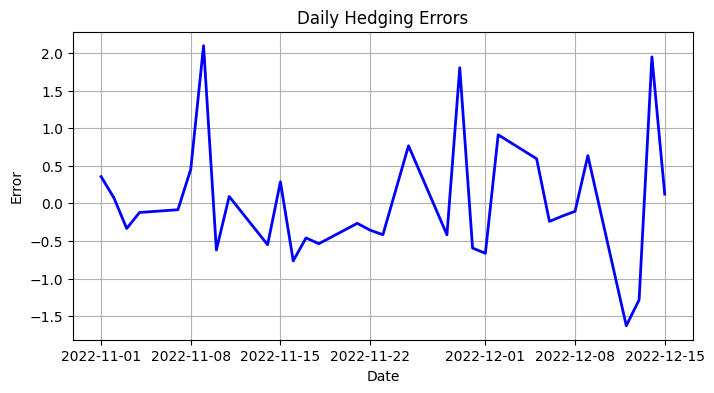

In [7]:
plot_hedging_errors(df_hedge, A_errors)

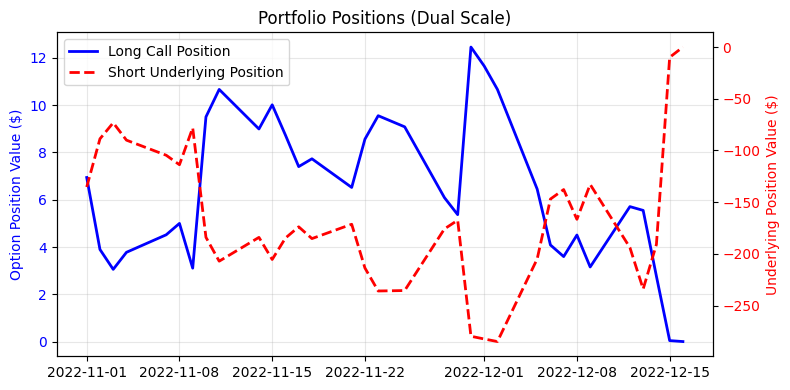

In [8]:
plot_positions(df_hedge, OP, RE, deltas)

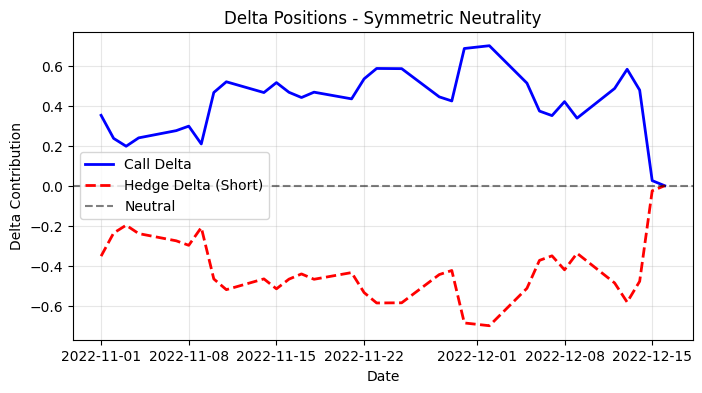

In [9]:
plot_delta_positions(df_hedge, deltas)

**Delta Hedging with transaction costs**

Now for a more realistic simulation with transaction costs, PnL calculations, and portfolio simulation.

In [10]:
maturity = pd.to_datetime('2022-12-16')
start_date = maturity - pd.Timedelta(days=45)
end_date = maturity - pd.Timedelta(days=0)

df_hedge, deltas, OP, RE, iv_values, A_errors, shares_held, cash_position, portfolio_values, cumulative_costs, pnl = delta_hedging(
    df, start_date=start_date, end_date=end_date, option_col="C400", K=400, r=0.05, 
    maturity=maturity, freq=1, transaction_cost_per_share=0.01, transaction_cost_percentage=0.0005
)

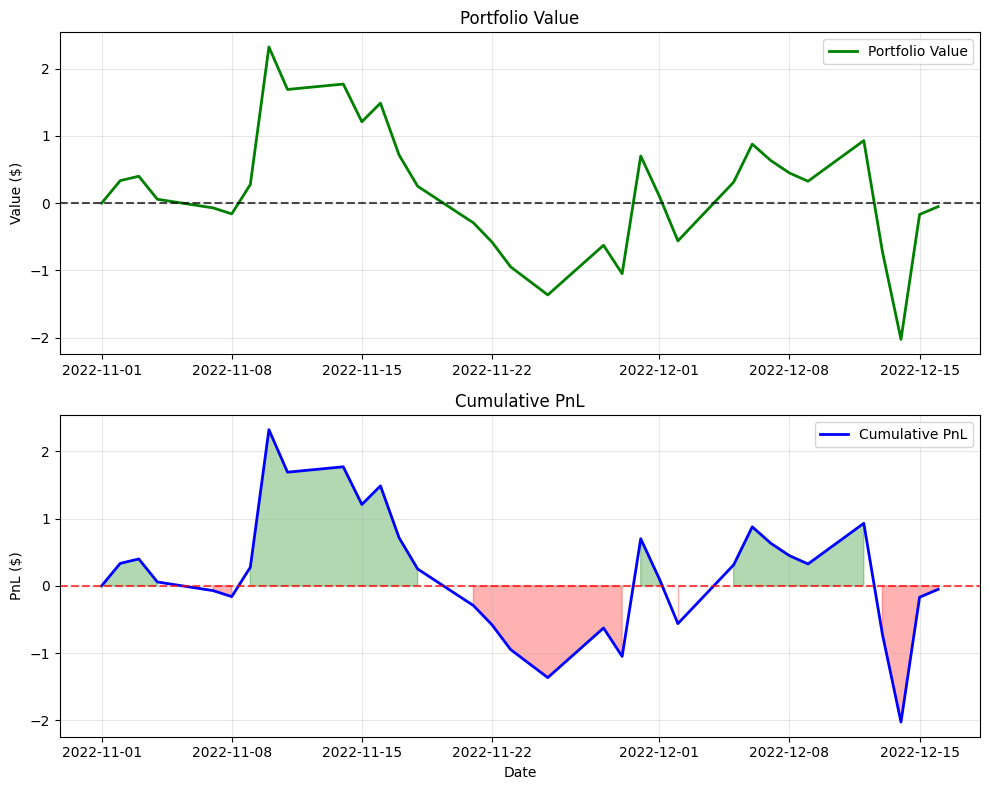

In [11]:
plot_portfolio_and_pnl(df_hedge.index, portfolio_values, pnl)

**Full analysis using 5 different data sets, ultimatly 157 simulations and then calculating averages and such.**

In [12]:
# Main analysis
data_folder = "simulation_data"
files = [f for f in os.listdir(data_folder) if f.endswith('.feather')]
all_stats = []

for file in files:
    df = data_load(os.path.join(data_folder, file))
    maturity = df.index[-1]
    
    call_cols = [col for col in df.columns if col.startswith('C')]
    
    for option_col in call_cols:
        try:
            K = int(option_col[1:])
        except ValueError:
            continue
                    
        stats_df = None
        lengths_tried = []
        
        for interval_length in [45, 30, 20]:
            step_size = max(5, interval_length // 4)
            lengths_tried.append(f"{interval_length}d(step{step_size})")
            
            temp_stats = run_hedging_intervals(
                df, maturity, 
                interval_length=interval_length, 
                step_size=step_size, 
                num_intervals=10,
                option_col=option_col, 
                K=K
            )
            
            if len(temp_stats) > 0:
                stats_df = temp_stats
                break
        
        if stats_df is not None:
            stats_df['dataset'] = file
            stats_df['option'] = option_col
            stats_df['strike'] = K
            stats_df['interval_length'] = interval_length
            all_stats.append(stats_df)

if all_stats:
    combined_stats = pd.concat(all_stats, ignore_index=True)
    print(len(combined_stats), "hedging simulations completed across all datasets and options.")
    length_summary = combined_stats.groupby('interval_length').size()

else:
    print("No results collected")


157 hedging simulations completed across all datasets and options.


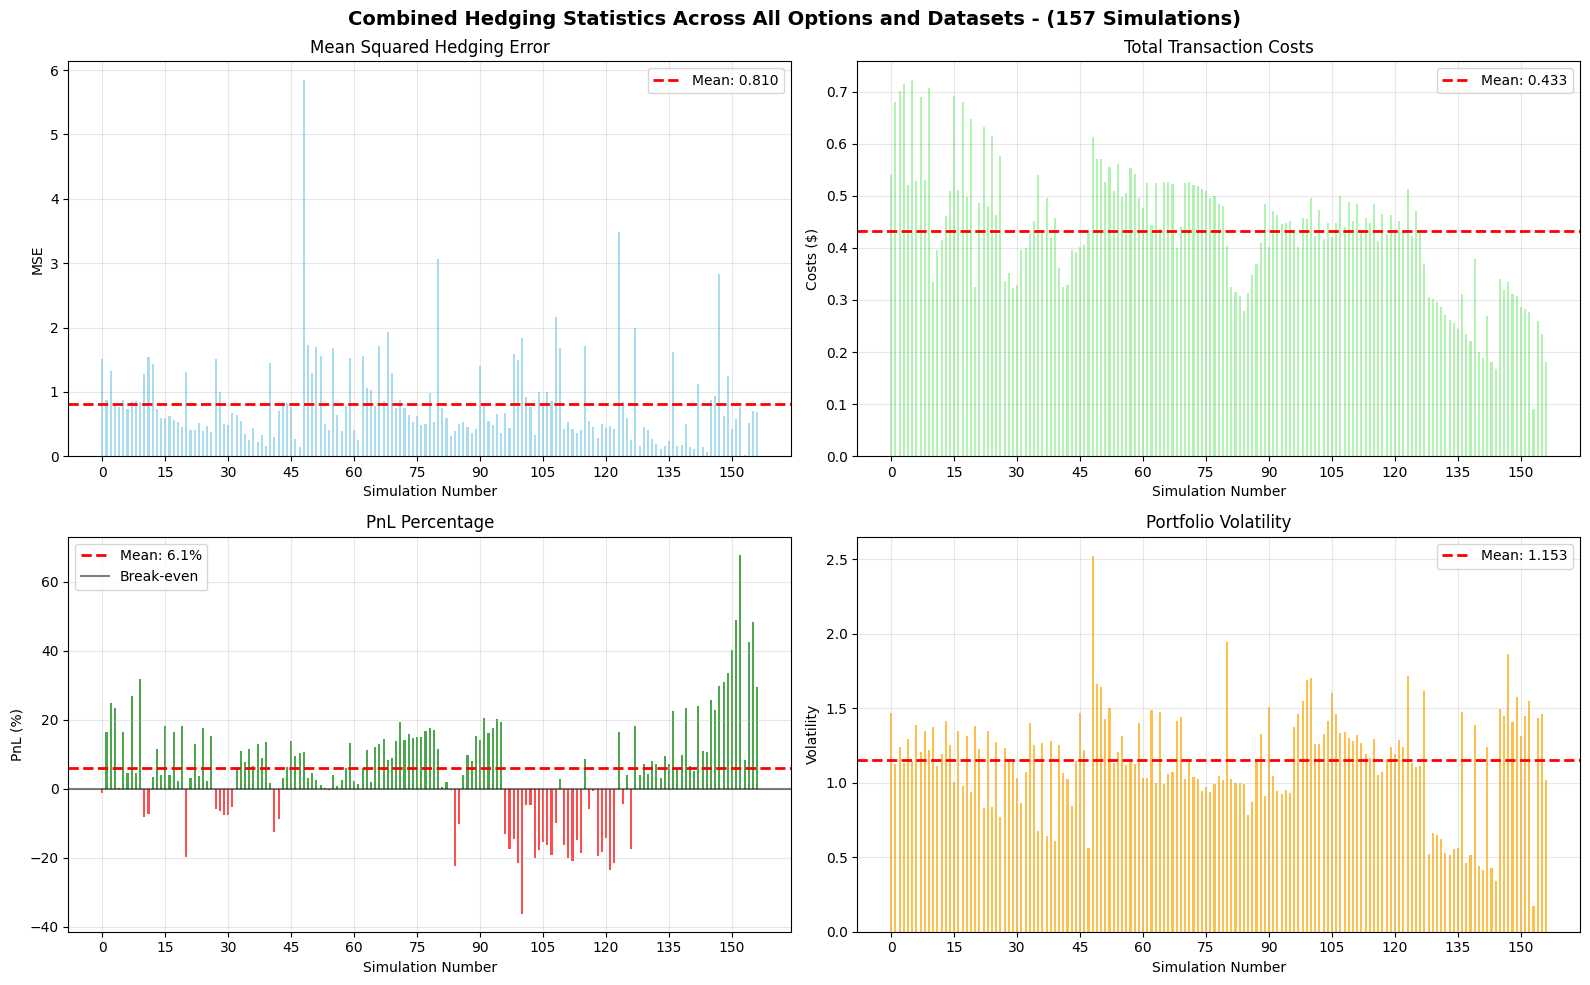

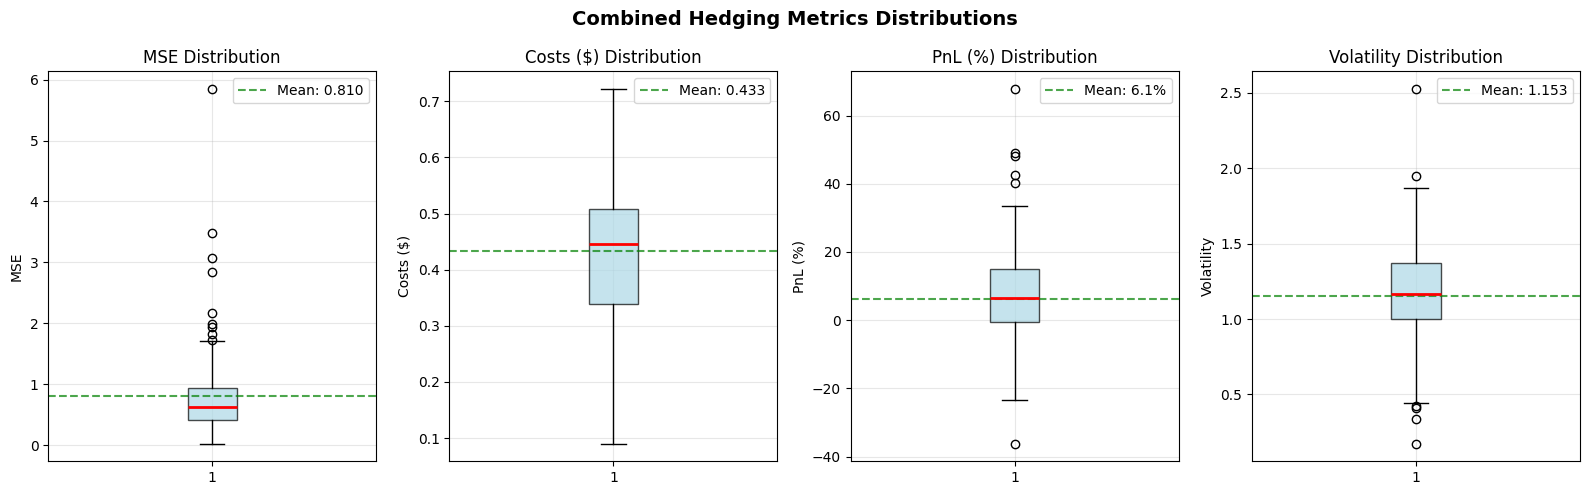

In [13]:
plot_hedging_simulation_stats(combined_stats, title="Combined Hedging Statistics Across All Options and Datasets - (157 Simulations)")
plot_hedging_summary_distributions(combined_stats, title="Combined Hedging Metrics Distributions")

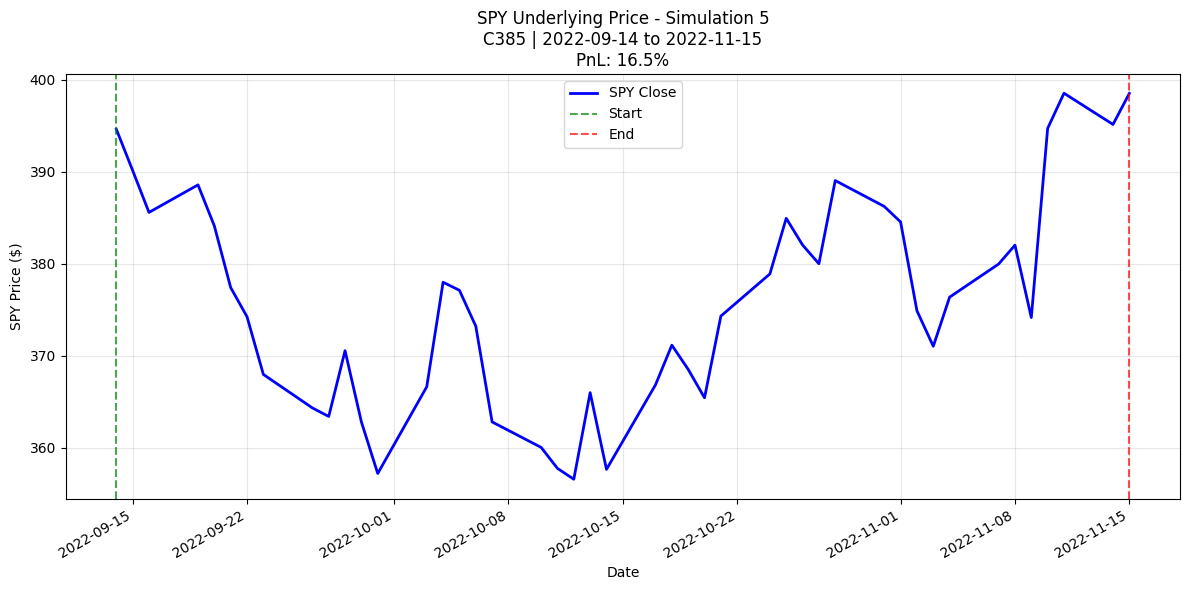

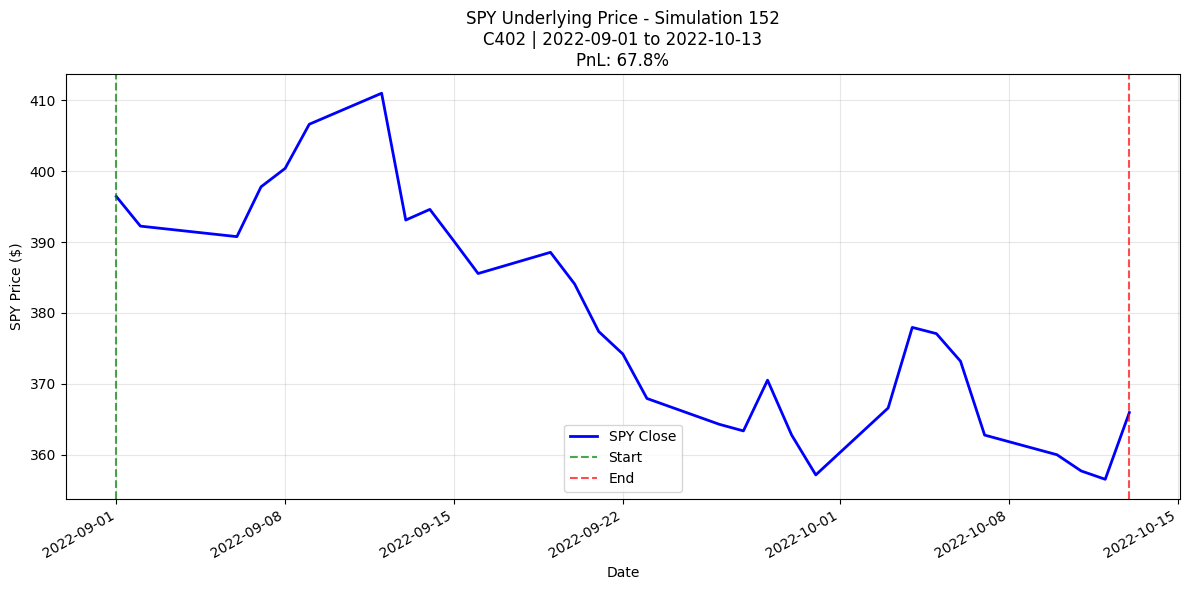

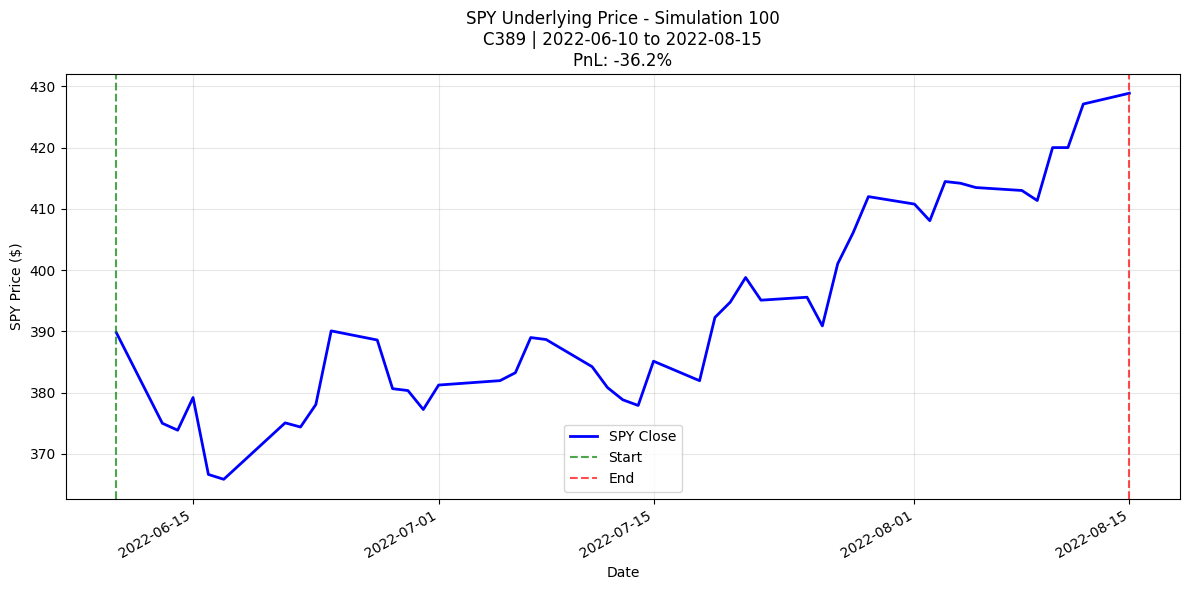

In [14]:
data_dict = {}
for file in files:
    df = data_load(os.path.join(data_folder, file))
    data_dict[file] = df

# Plot underlying for simulation 5
plot_underlying_for_simulation(combined_stats, 5, data_dict)

# Plot for the best performing simulation
best_idx = combined_stats['pnl_percentage'].idxmax()
plot_underlying_for_simulation(combined_stats, best_idx, data_dict)

# Plot for the worst performing simulation  
worst_idx = combined_stats['pnl_percentage'].idxmin()
plot_underlying_for_simulation(combined_stats, worst_idx, data_dict)


Now Delta-Vega Hedging,

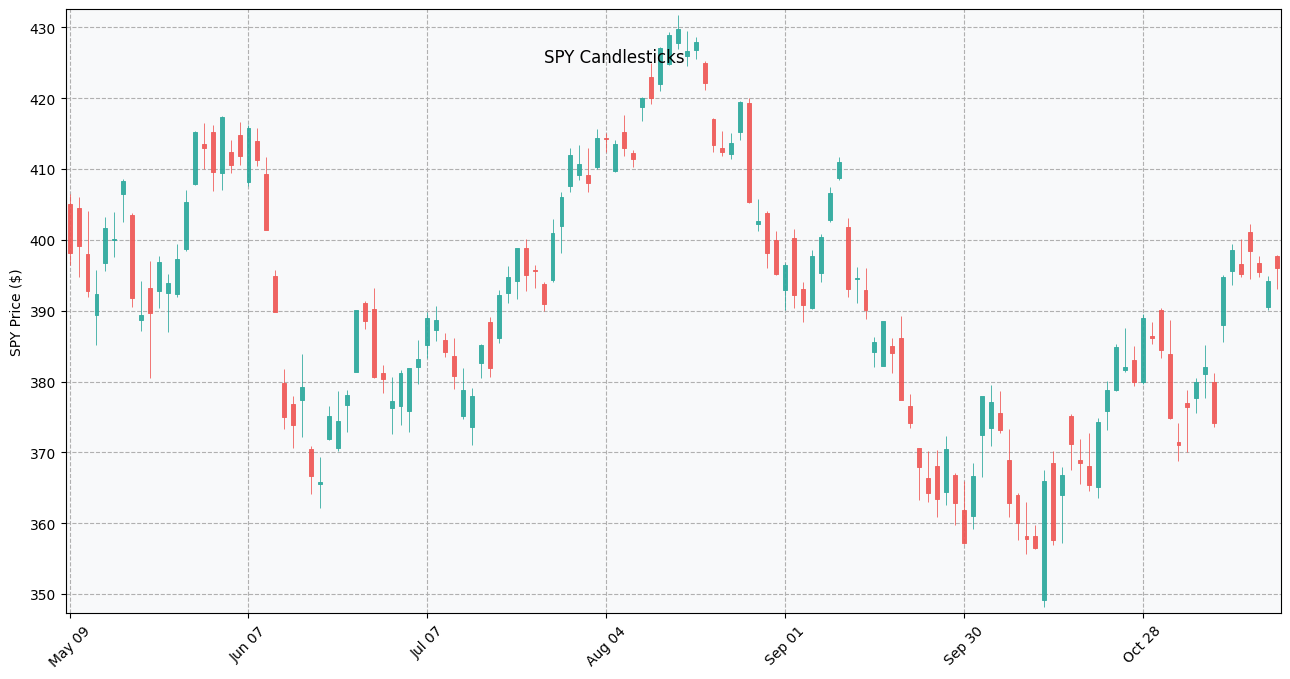

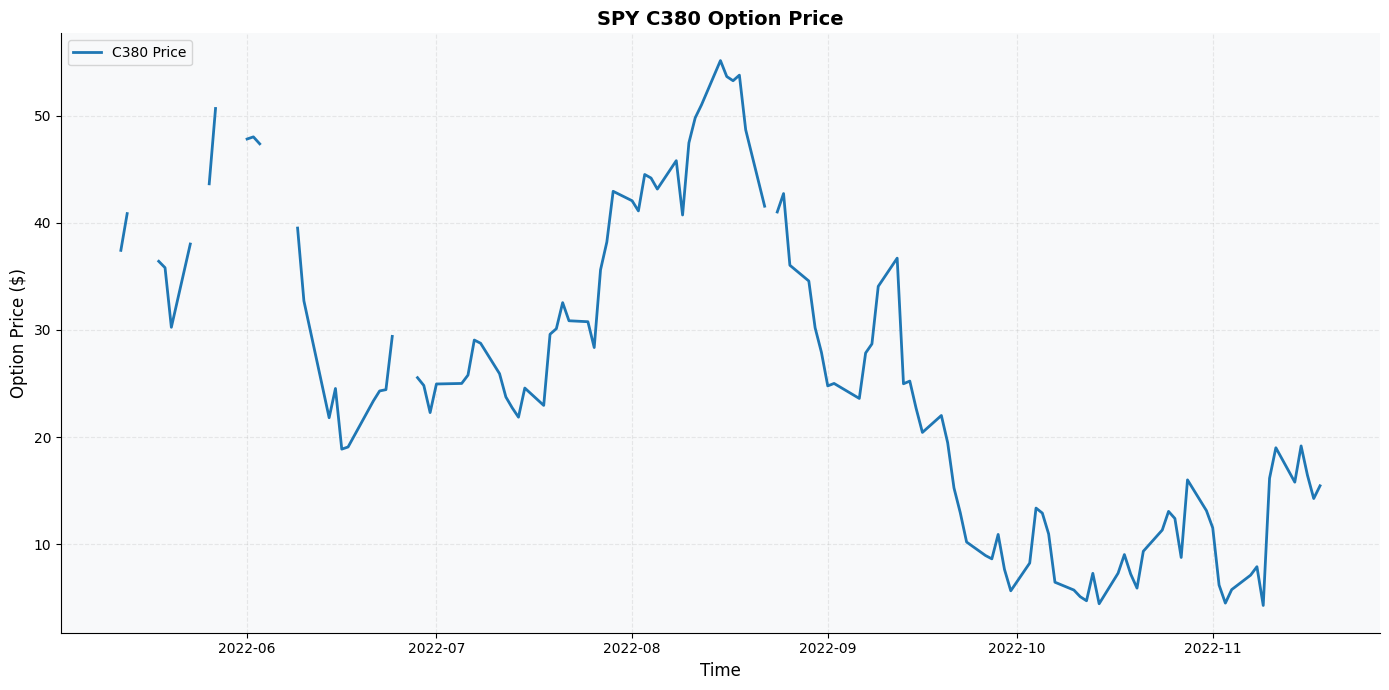

Data starts: 2022-05-09 00:00:00
Data ends: 2022-11-18 00:00:00
Number of days: 193
Number of data points: 136


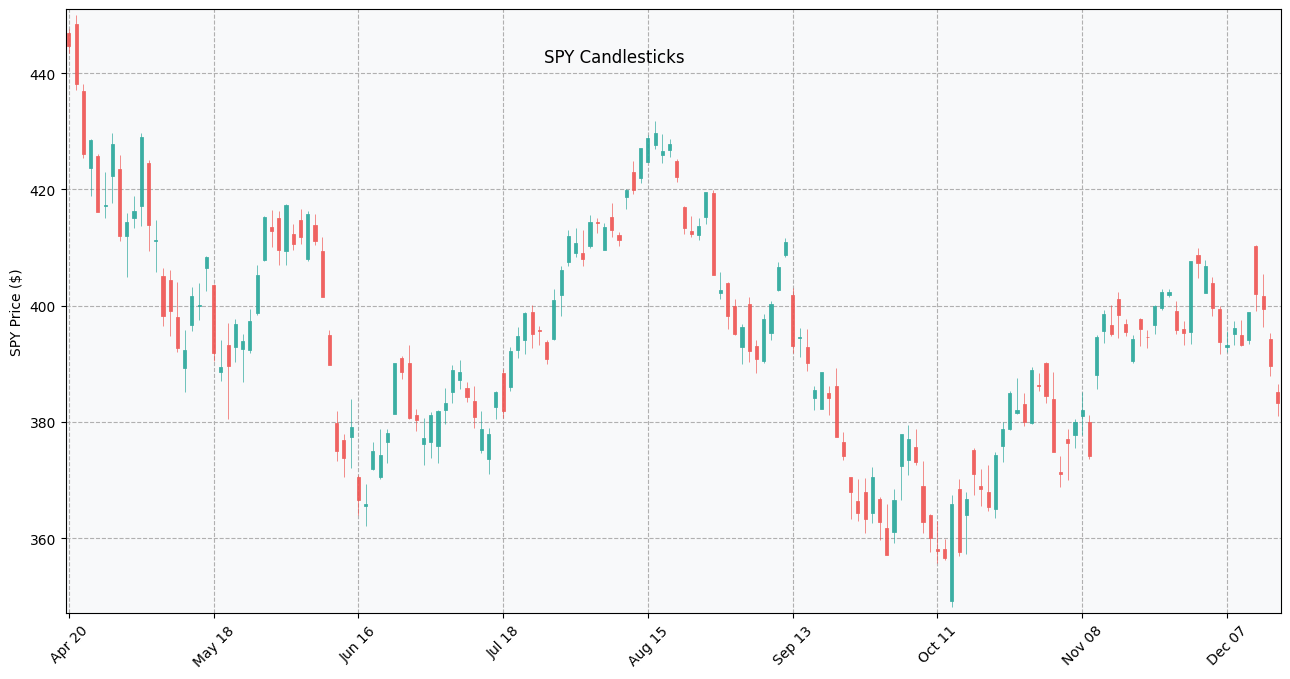

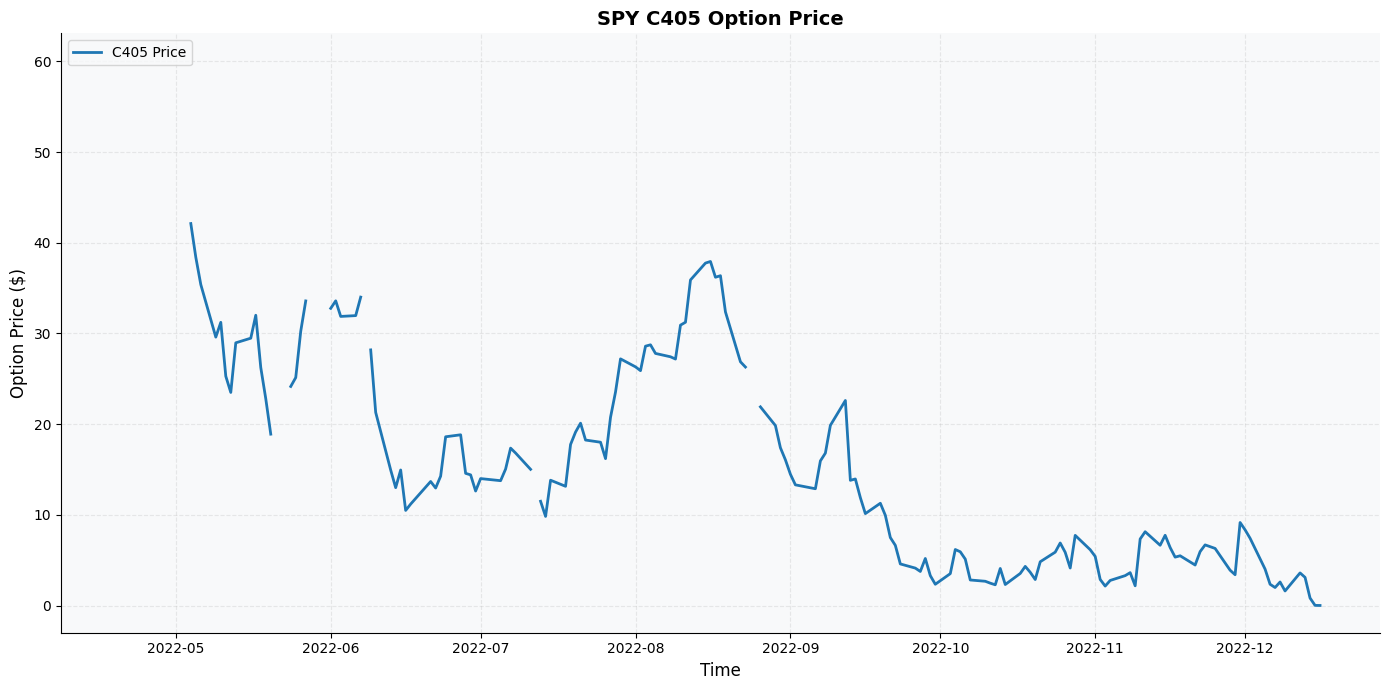

Data starts: 2022-04-20 00:00:00
Data ends: 2022-12-16 00:00:00
Number of days: 240
Number of data points: 168


In [15]:
# Load two datasets
df1 = data_load("simulation_data/spy_221118_C380_C405.feather")
df2 = data_load("simulation_data/spy_221216_C380_C405.feather")

plot_spy_and_options(df1, ["C380"])
plot_spy_and_options(df2, ["C405"])

In [16]:
start_date = pd.to_datetime('2022-10-01')
end_date = start_date + pd.Timedelta(days=45)

# Run delta-vega hedging
result = delta_vega_hedging(
    df1=df1, df2=df2,
    start_date=start_date, end_date=end_date,
    option_primary="C400", option_vega="C400",
    K_primary=400, K_vega=400,
    r=0.05, maturity1=df1.index[-1], maturity2=df2.index[-1],
    transaction_cost_per_share=0.01,
    transaction_cost_percentage=0.0005    
)


df_hedge, net_deltas, alphas, OP1, OP2, RE, iv1, iv2, A_errors, shares, vega_pos, cash, port_val, costs, pnl = result

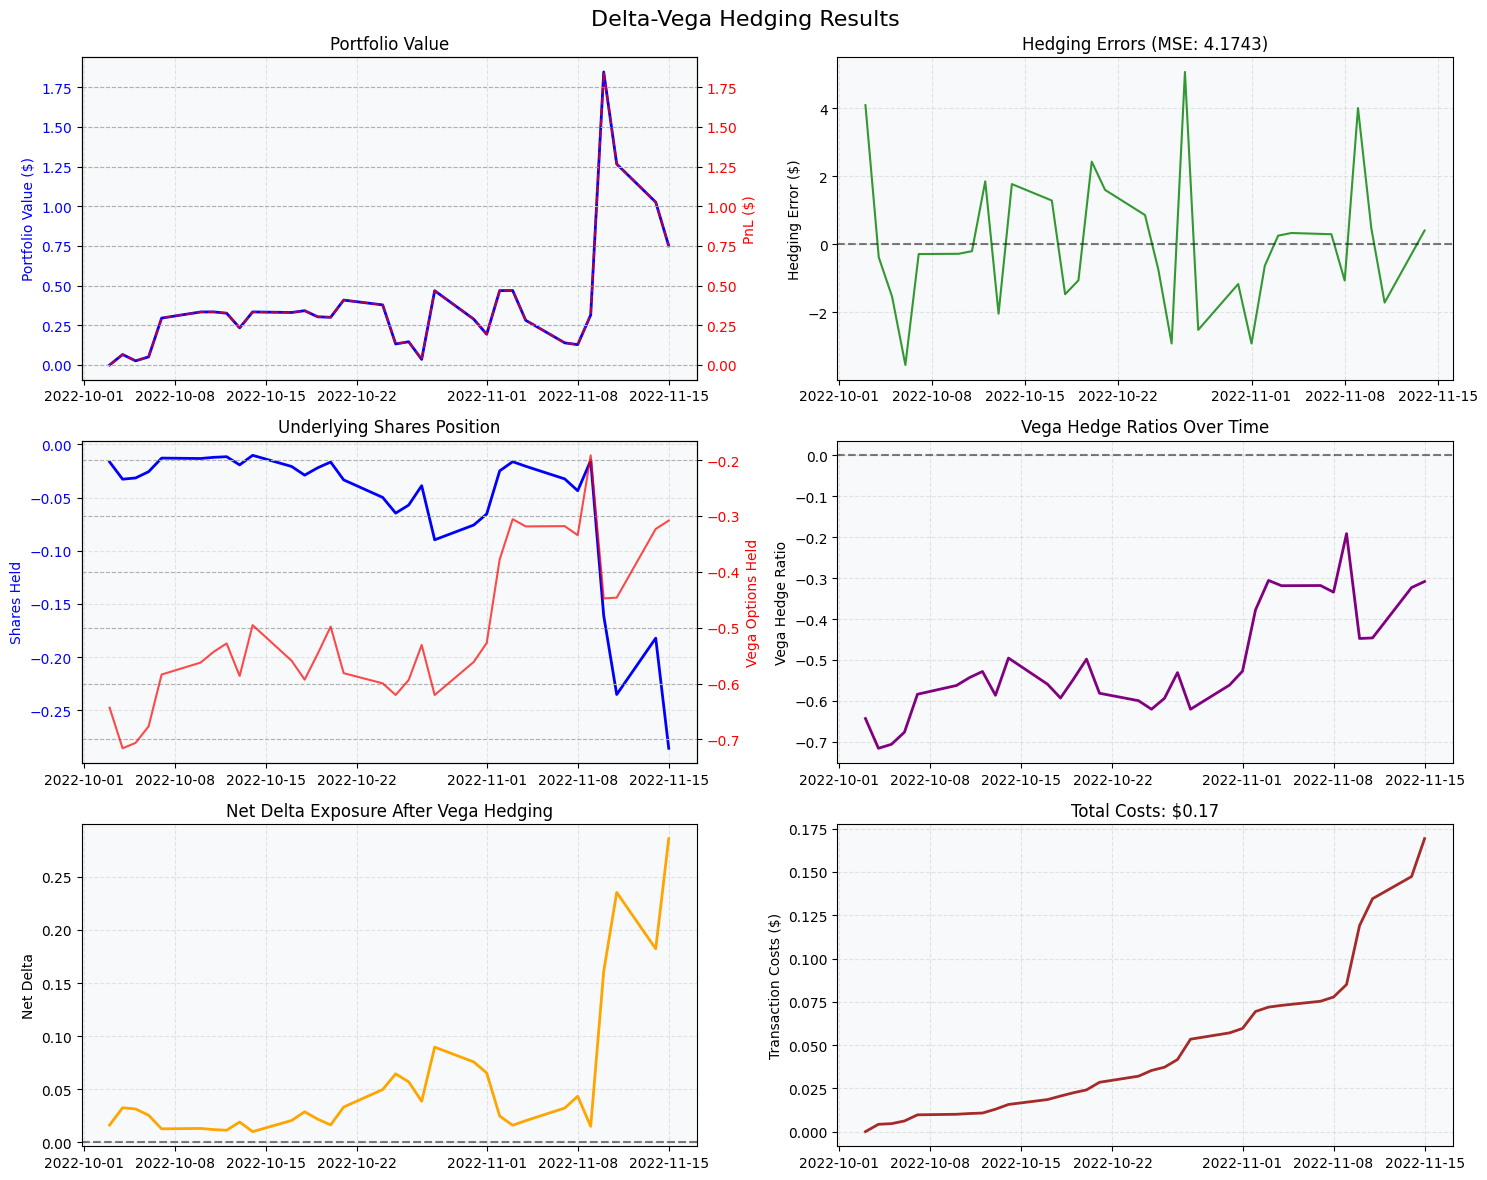

=== DELTA-VEGA HEDGING SUMMARY ===
MSE: 4.1743
RMSE: 2.0431
Mean Error: 0.0075
Final PnL: $0.75
Total Costs: $0.17
Average Vega Ratio: -0.5077
Final Net Delta: 0.2858


In [17]:
plot_delta_vega_hedging(df_hedge, net_deltas, alphas, OP1, OP2, RE, A_errors, shares, vega_pos, port_val, costs, pnl)